# MATA50 - Exercícios da Semana 04

*   Aluno: Gustavo Mendel Queiroz e Souza



# Instruções (não apagar)
1.   Após criar este notebook, altere o nome do notebook/documentação incluindo o nome do vegetal do seu grupo. Por exemplo, se você é do grupo Carambola, altere o nome do notebook para "MATA50-Semana04-Carambola.ipynb"
1. Compartilhe este documento com todos os membros do grupo (para participarem da elaboração deste documento). É importante que o notebook utilizado seja o mesmo compartilhado para que os registros de participação e colaboração fiquem salvos no histórico.
1.   Incluia o nome completo dos autores na lista de autores que auxiliaram na elaboração deste notebook. Destaque o responsável como sendo o(a) primeiro(a) autor(a).
1. Utilize os recursos de blocos de texto e de código para adicionar as suas respostas, sem alterar os blocos de texto e código existente. Não economize, esses blocos são de graça.
1. Ao concluir a atividade, compartilhe o notebook com januario.ufba@gmail.com (dando permisão para edição) e deixando o aviso de notificação marcado, para que eu receba o seu e-mail.



In [2]:
#@title Implementação dos modelos em Python
#@markdown Esta célula contém a implementação em Python 3 dos principais modelos de computação vistos na disciplina de Linguagens Formais e Autômatos. 
#@markdown Não é necessário conhecer o código aqui implementado ou mesmo ter um conhecimento profundo da linguagem Python. Acompanhe os exemplos e experimente construir seus próprios modelos.
 
#@markdown >*Execute esta célula (`ctrl+enter` ou clicando no botão ao lado) para que o ambiente seja carregado com as classes implementadas.*
 
from graphviz import Digraph
import re
 
class AP: 
    def __init__(self, Q={}, Sigma={}, Gamma={}, delta={}, q0=0, F={}):
        self.states = Q
        self.inputAlphabet = Sigma
        self.stackAlphabet = Gamma
        self.transition = delta
        self.startState = q0
        self.acceptStates = F 
 
        self.initialize()
 
    def initialize(self, input_string=""):
        self.traces = [[(self.startState,tuple(input_string),())]]
 
    def check(self):
        pass
        
    def hasNext(self):
        return self.traces and (not self.acceptTraces())
    
    def acceptTraces(self):
        return [t for t in self.traces if t[-1][1] == () and t[-1][0] in self.acceptStates]
 
    def step(self):
        updated_traces = []
        for trace in self.traces:
          s, string, stack = trace[-1]
          A = {'', string[0]} if string else {''}
          B = {'', stack[-1]} if stack else {''}
          possible_transitions = [(s,a,b) for a in A for b in B if (s,a,b) in self.transition]          
          for (s,a,b) in possible_transitions:  
            for r,c in self.transition[s,a,b]:
              nstring = string[1:] if a else string
              nstack  = stack[:-1] if b else stack
              nstack  = nstack+(c,) if c else nstack
              if (not (r,nstring,nstack) in trace):
                updated_traces.append(trace+[(r,nstring,nstack)])
        self.traces = updated_traces
 
    def run(self, input_string=0, max_steps=1000):        
        while (self.hasNext()): 
          if max_steps == 0: 
            raise Exception("Timeout")
          self.step()
          max_steps -= 1
        return self.result()
 
    def aceita(self, input_string=0):
        self.initialize(input_string)
        return self.run()
 
    def result(self):
        return True if self.acceptTraces() else (False if (not self.traces) else None)
    
    def visualizar(self):      
        f = Digraph('finite_state_machine', filename='fsm.gv')
        f.attr(rankdir='LR', size='8,5')
 
        f.attr('node', shape='point')
        f.node('')
        
        f.attr('node', shape='doublecircle')
        for n in self.acceptStates:
          f.node(str(n))
 
        f.attr('node', shape='circle')
        for n in self.states.difference(self.acceptStates):
          f.node(str(n))
 
        label = {}        
        for (q,a,b) in self.transition:
          for (r,c) in self.transition[q,a,b]:          
            label[q,r] = label[q,r]+[(a,b,c)] if (q,r) in label else [(a,b,c)]
 
        f.edge('', str(self.startState))
        for (q,r) in label:
          f.edge(str(q),str(r),label=self.graphviz_edge_label_format(label[q,r]))      
          pass
        
        return f
    
    def graphviz_edge_label_format(self,labels=[]):
        epsilon = "\u03BB"
        right_arrow = "\u2192"
        return '\n'.join([(a if (a or a==0) else epsilon) + "," + (b if (b or b==0) else epsilon) + right_arrow + (c if (c or c==0) else epsilon) for (a,b,c) in labels])
        # return '\n'.join([(str(a) if a else epsilon) + "," + (str(b) if b else epsilon) + right_arrow + (str(c) if c else epsilon) for (a,b,c) in labels])
 
class AFN(AP):
  def __init__(self, Q={}, Sigma={}, delta={}, q0=0, F={}):
        delta_pda = {}
        for q,a in delta:
          delta_pda[q,a,''] = {(r,'') for r in delta[q,a]}
        super().__init__(Q,Sigma,{},delta_pda,q0,F)
  
  def graphviz_edge_label_format(self,labels):
      epsilon = "\u03B5"
      return ",".join([(str(a) if (a or a==0) else epsilon) for (a,b,c) in labels])
 
class AFD(AFN):
  def __init__(self, Q={}, Sigma={}, delta={}, q0=0, F={}):
        delta_nfa = {}
        for (q,a) in delta:
          delta_nfa[q,a] = {delta[q,a]}
        super().__init__(Q,Sigma,delta_nfa,q0,F)
 
class ER:
  def __init__(self,regex=None):  
    if (regex == None):
      self.regex = None
    elif (re.match("^[a-zA-Z0-9\(\)\|\*]*$", regex)):
      self.regex = regex
    else:
      raise Exception("Invalid pattern")
 
  def gera(self, input_string):
    if (self.regex == None):
      return False
    else:
      return True if re.match("^"+self.regex+"$",input_string) else False
 
class GLC:
  def __init__(self,V,Sigma,R,S):
      self.variables = V
      self.terminals = Sigma
      # self.rules = R
      self.rules = {(a, tuple(b)) for (a,b) in R}
      self.start = S
 
      self.derivation = []
      self.chomsky = None
  
  def gera(self, string):
      if (not self.chomsky):
        self.chomsky = self.to_chomsky()        
      G = self.chomsky
      
      if len(string) == 0: return (G.start,()) in G.rules
 
      # CYK Algorithm
      n = len(string)
      P = [[[] for x in range(n - y)] for y in range(n)]
      for i,c in enumerate(string):
        for v in [a for (a,b) in G.rules if len(b) == 1 and c in b]:
          P[0][i] += [v]
      for l in range(2, n+1): # borda da iteração
        for s in range(0, n+1-l): # coluna
          for p in range(1, l): # linha
            for u, v in [(a,b) for (a,b) in G.rules if len(b) == 2]:
              if v[0] in P[p-1][s] and v[1] in P[l-p-1][s+p]:
                P[l-1][s] += [u]
      return G.start in P[-1][0]
 
  def print(self):
      rightarrow = "\u2192"
      print(self.start,rightarrow, '|'.join([''.join(y) for x,y in self.rules if x == S]))
      for v in sorted(self.variables.difference(self.start)): 
        print(v,rightarrow, '|'.join([''.join(y) for x,y in self.rules if x == v]))
 
  def replace_eps(self, v, l):
    if not l: return {()}
    result = {(l[0],) + s for s in self.replace_eps(v, tuple(l[1:]))}
    if l[0] == v:
      result.update({tuple(s[1:]) for s in result})
    return result   
 
  def to_chomsky(self):
      n_state = 0
      
      S = '<{}>'.format(n_state)
      Sigma = self.terminals 
      V = {S}.union(self.variables)
      R = {(S,(self.start,))}.union(self.rules)
 
      target = {alpha for alpha in self.variables if (alpha,()) in R}
      while (target):
        for e in target:
          rules = {(alpha,beta) for (alpha,beta) in R if e in beta}
          for (a,b) in rules:
            R.update({(a, beta) for beta in self.replace_eps(e,b)})
          R.discard((e,()))
        target = {alpha for alpha in self.variables if (alpha,()) in R}
      
      target = {(a,b) for (a,b) in R if len(b) == 1 and b[0] in V}
      while (target):
        for u,v in target:
          rules = {b for (a,b) in R if a == v[0]}
          R.update({(u,b) for b in rules})
          R.discard((u,v))
        target = {(a,b) for (a,b) in R if len(b) == 1 and b[0] in V}
      
      target = {(alpha,beta) for (alpha,beta) in R if len(beta) > 2}
      while(target):
        for u,v in target:
          n_state += 1
          state = '<{}>'.format(n_state)
          V.update({state})
          R.update({(u,(v[0],state)),(state, tuple(v[1:]))})
          R.discard((u,v))
        target = {(alpha,beta) for (alpha,beta) in R if len(beta) > 2}
 
      target = {(alpha,beta) for (alpha,beta) in R if len(beta) == 2}
      for u,v in target:
        n = list(v)
        for i in range(2):
          if v[i] in Sigma:
            R.discard((u,(n[0],n[1])))
            n_state += 1
            n[i] = '<{}>'.format(n_state)
            V.update({n[i]})
            R.update({(u,(n[0],n[1]))})
            R.update({(n[i],(v[i],))})
 
      return GLC(V,Sigma,R,S)

# Exemplos (Apague os exemplos abaixo antes de compartilhar com o professor)

In [ ]:
#@title 1. Construa um AFD para a seguinte linguagem sobre o alfabeto $\Sigma = \{0, 1\}$: O conjunto das palavras que contem um ou dois 1’s, cujo tamanho é múltiplo de 3.
Q = {'z1r0','z1r1','z1r2','u1r0','u1r1','u1r2','d1r0','d1r1','d1r2'}
Sigma = {'0','1'}
delta = {('z1r0','0'):'z1r1',
         ('z1r1','0'):'z1r2',
         ('z1r2','0'):'z1r0',
         ('u1r0','0'):'u1r1',
         ('u1r1','0'):'u1r2',
         ('u1r2','0'):'u1r0',
         ('d1r0','0'):'d1r1',
         ('d1r1','0'):'d1r2',
         ('d1r2','0'):'d1r0',
         ('z1r0','1'):'u1r1',
         ('z1r1','1'):'u1r2',
         ('z1r2','1'):'u1r0',
         ('u1r0','1'):'d1r1',
         ('u1r1','1'):'d1r2',
         ('u1r2','1'):'d1r0'}
q0 = 'z1r0'
F = {'u1r0','d1r0'}
 
M = AFD(Q,Sigma,delta,q0,F)
M.visualizar()
M.aceita("100")

True

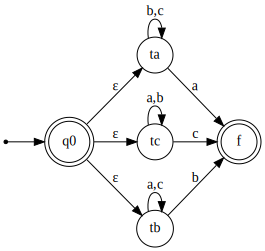

In [ ]:
#@title 2. Construa um AFN sobre $\Sigma = \{a, b, c\}$ que reconheça o conjunto das palavras em que o último símbolo não tenha ocorrido antes.
Q = {'q0','ta','tb','tc','f'}
Sigma = {'a','b','c'}
delta = {('q0',''):{'ta','tb','tc'},
         ('ta','b'):{'ta'},
         ('ta','c'):{'ta'},
         ('tb','a'):{'tb'},
         ('tb','c'):{'tb'},
         ('tc','a'):{'tc'},
         ('tc','b'):{'tc'},
         ('ta','a'):{'f'},
         ('tb','b'):{'f'},
         ('tc','c'):{'f'}}
q0 = 'q0'
F = {'q0','f'}
 
M = AFN(Q,Sigma,delta,q0,F)
M.visualizar()
# M.aceita("aacacacacccacaccacaacab")

# Exercícios

1. Construa um AFD para a seguinte linguagem sobre o alfabeto $\Sigma = \{0, 1\}$: $\{w \in \{0, 1\}^* \mid $ cada 0 de $w$ é imediatamente seguido de, no mínimo, dois 1's$\}.$

True
True
True
False
True
False


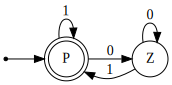

In [4]:
Q = {'P', 'Z'}
Sigma = {'0','1'}
delta = {
    ('P', '1'): 'P',
    ('P', '0'): 'Z',
    ('Z', '0'): 'Z',
    ('Z', '1'): 'P',
}
q0 = 'P'
F = {'P'}
 
M = AFD(Q,Sigma,delta,q0,F)
print(M.aceita("011001"))
print(M.aceita("0110011111111111"))
print(M.aceita("01"))
print(M.aceita("01100100000"))
print(M.aceita(""))
print(M.aceita("0"))
M.visualizar()

2. Construa um AFD para a seguinte linguagem sobre o alfabeto $\Sigma = \{0, 1\}$: O conjunto das palavras com no maximo três 1’s.

True
False
True
False


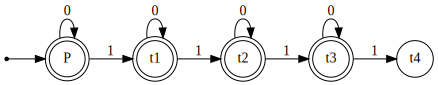

In [ ]:
Q = {'P', 't1', 't2', 't3', 't4'}
Sigma = {'0','1'}
delta = {
    ('P', '0'): 'P',
    ('P', '1'): 't1',
    ('t1', '0'): 't1',
    ('t1', '1'): 't2',
    ('t2', '0'): 't2',
    ('t2', '1'): 't3',
    ('t3', '0'): 't3',
    ('t3', '1'): 't4',
}
q0 = 'P'
F = {'P', 't1', 't2', 't3'}
 
M = AFD(Q,Sigma,delta,q0,F)
print(M.aceita("111"))
print(M.aceita("1111"))
print(M.aceita("0100100010000"))
print(M.aceita("01001000100001"))
M.visualizar()

3. Construa um AFN sobre $\Sigma = \{a, b, c\}$ que reconheça o conjunto das palavras em que o último símbolo seja diferente do primeiro.


True
False
False
False
True


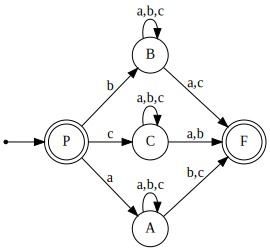

In [ ]:
Q = {'P', 'A', 'B', 'C', 'F'}
Sigma = {'a','b','c'}
delta = {
  ('P', 'a'): {'A'},
  ('P', 'b'): {'B'},
  ('P', 'c'): {'C'},
  ('A', 'a'): {'A'},
  ('A', 'b'): {'A', 'F'},
  ('A', 'c'): {'A', 'F'},
  ('B', 'a'): {'B', 'F'},
  ('B', 'b'): {'B'},
  ('B', 'c'): {'B', 'F'},
  ('C', 'a'): {'C', 'F'},
  ('C', 'b'): {'C', 'F'},
  ('C', 'c'): {'C'},
}
q0 = 'P'
F = {'P' ,'F'}
 
M = AFN(Q,Sigma,delta,q0,F)
print(M.aceita("abc"))
print(M.aceita("aba"))
print(M.aceita("baaccacb"))
print(M.aceita("cababsbcbacsbc"))
print(M.aceita("cabcbabcabcbabcbacb"))
M.visualizar()

4. Construa um AFN sobre $\Sigma = \{a, b, c\}$ que reconheça o conjunto das palavras com sufixo $abc$ ou $bca$. 

True
True
False


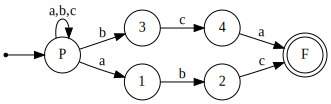

In [ ]:
Q = {'P','1','2','3','4','F'}
Sigma = {'a','b','c'}
delta = {
  ('P', 'a'): {'P', '1'},
  ('P', 'b'): {'P', '3'},
  ('P', 'c'): {'P'},
  ('1', 'b'): {'2'},
  ('2', 'c'): {'F'},
  ('3', 'c'): {'4'},
  ('4', 'a'): {'F'},
}
q0 = 'P'
F = {'F'}
 
M = AFN(Q,Sigma,delta,q0,F)
print(M.aceita("abccabababc"))
print(M.aceita("abccababca"))
print(M.aceita("aacbbabcabbc"))
M.visualizar()